# Predict Loan Status Using Lending Club's Loan Data

The data is coming from Lending Club 2016 Q1.

The dataset includes 133889 obs. and 145 features.

In [1]:
loan <- read.csv('LoanStats_2016Q1.csv', header = TRUE, stringsAsFactors = FALSE, skip = 1)

In [2]:
loanT <- loan

In [3]:
head(loan)

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,⋯,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
,NA,12000,12000,12000,60 months,6.97%,237.45,A,A3,⋯,NA,NA,Cash,N,,,,NA,NA,NA
,NA,8000,8000,8000,36 months,11.99%,265.68,C,C1,⋯,NA,NA,Cash,N,,,,NA,NA,NA
,NA,8200,8200,8200,36 months,11.47%,270.29,B,B5,⋯,NA,NA,Cash,N,,,,NA,NA,NA
,NA,14000,14000,14000,36 months,10.75%,456.69,B,B4,⋯,NA,NA,Cash,N,,,,NA,NA,NA
,NA,15000,15000,15000,36 months,9.16%,478.12,B,B2,⋯,NA,NA,Cash,N,,,,NA,NA,NA
,NA,7000,7000,7000,36 months,7.39%,217.40,A,A4,⋯,NA,NA,Cash,N,,,,NA,NA,NA


In [4]:
dim(loan)

[1] 133889    145

## Data Preprocessing 

Cleaning processes:

- make date related features in standard format

- remove features with same value and with unique values per row

- treat features with too many values

- remove redundant features and add new features

- convert 'loan_status' to booleans

- deal with missing values

- detect and deal with outliers


In [5]:
# check the response feature loan_status
table(loan$loan_status)


                          Charged Off            Current            Default 
                 2              18465              61555                  5 
        Fully Paid    In Grace Period  Late (16-30 days) Late (31-120 days) 
             50509               1194                369               1790 

In [6]:
loan <- subset(loan, loan_status != "")

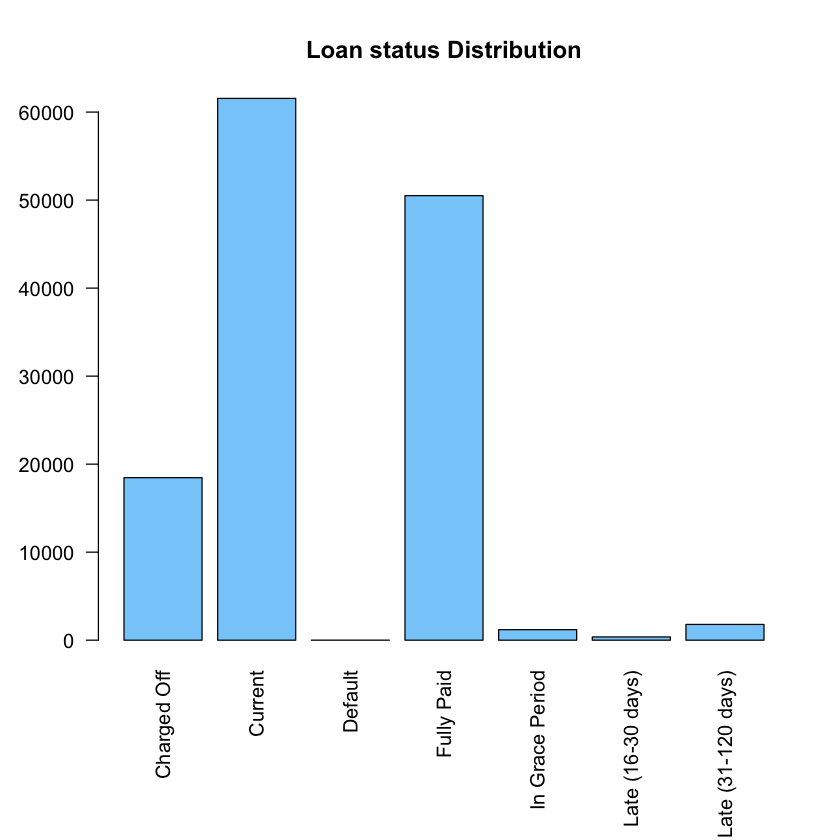

In [7]:
counts <- table(loan$loan_status)
par(mar = c(8.1,4.1,4.1,2.1))
barplot(counts, main = 'Loan status Distribution', col = 'lightskyblue',las = 2,
        names.arg = c('Charged Off','Current','Default','Fully Paid','In Grace Period',
                      'Late (16-30 days)','Late (31-120 days)'))

In [8]:
# check the relationship between loan status and last/next pymnt d 
with(subset(loan, next_pymnt_d == ""), table(loan_status))
with(subset(loan, last_pymnt_d == ""), table(loan_status))

loan_status
Charged Off  Fully Paid 
      18465       50509 

loan_status
Charged Off 
        148 

If no last_pymnt_d, the loan_status is charged_off; if no next_pymnt_d, the loan_status is full_paid or charged_off.

In [9]:
# find out all date related features
date.cols <- colnames(loan)[c(which(grepl('_d$', colnames(loan))),
                              which(grepl('_date$', colnames(loan))))]
date.cols

[1] "issue_d"                   "last_pymnt_d"             
[3] "next_pymnt_d"              "last_credit_pull_d"       
[5] "hardship_start_date"       "hardship_end_date"        
[7] "payment_plan_start_date"   "debt_settlement_flag_date"
[9] "settlement_date"

In [10]:
# standard date format
library(zoo)
for (col_i in date.cols) {
  loan[, col_i] <-  as.Date(as.yearmon(loan[, col_i], "%b-%Y"))
}


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [11]:
# create new features based on date related features with months
loan$mths_since_last_credit_pull <- as.integer((as.Date('2018-07-01')-loan$last_credit_pull_d)/30)
loan$mths_since_issue <- as.integer((as.Date('2018-07-01')-loan$issue_d)/30)
TransformToLengthFromIssueDate <- function(loan, col.name, new.col.name, other.level) {
  month.cnt <- as.integer((loan[, col.name]-loan$issue_d)/30)
  loan[, new.col.name] <- ifelse(is.na(loan[, col.name]), other.level,
                                 as.character(cut(month.cnt, 
                                                  c(min(month.cnt, na.rm = T) - 1,
                                                    quantile(month.cnt, c(0.1, 0.9), na.rm = T),
                                                    max(month.cnt, na.rm = T)))))
  return(loan)
}
loan <- TransformToLengthFromIssueDate(loan, 'hardship_start_date' ,'hardship_since_issue', 'no_hardship')
loan <- TransformToLengthFromIssueDate(loan, 'settlement_date' ,'settlement_since_issue', 'no_settlement')

In [12]:
# create new feature last_pymnt_from_issue and group as categorical feature
loan$last_pymnt_from_issue <- with(loan, last_pymnt_d - issue_d)
loan$last_pymnt_from_issue_cat <- with(loan, as.character(cut(as.numeric(last_pymnt_from_issue),
                                                             c(-1,0,30,92,184,275,366,549,732,915))))
loan$last_pymnt_from_issue_cat[which(is.na(loan$last_pymnt_from_issue_cat))]<- 'no pymnt'

In [13]:
# check if last pymnt from issue could be a useful feature
by.pymnt.gap <- with(loan, table(last_pymnt_from_issue_cat, loan_status))
by.pymnt.gap <- by.pymnt.gap[c("(-1,0]", "(0,30]", "(30,92]", "(92,184]", "(184,275]",
                               "(275,366]", "(366,549]", "(549,732]", "(732,915]", "no pymnt"),
                             c("Charged Off", "Default", "Late (31-120 days)",
                               "Late (16-30 days)", "In Grace Period", "Current",
                               "Fully Paid")]
round(100*by.pymnt.gap/apply(by.pymnt.gap, 1, sum), 2)

                         loan_status
last_pymnt_from_issue_cat Charged Off Default Late (31-120 days)
                (-1,0]           0.00    0.00               0.00
                (0,30]          11.87    0.00               0.00
                (30,92]         22.35    0.00               0.00
                (92,184]        36.51    0.00               0.00
                (184,275]       36.87    0.00               0.00
                (275,366]       33.25    0.00               0.00
                (366,549]       30.83    0.00               0.00
                (549,732]       21.04    0.01               2.61
                (732,915]        0.67    0.01               1.88
                no pymnt       100.00    0.00               0.00
                         loan_status
last_pymnt_from_issue_cat Late (16-30 days) In Grace Period Current Fully Paid
                (-1,0]                 0.00            0.00    0.00     100.00
                (0,30]                 0.00          

With the increase of last_pymnt_from_issue, loan_status changed: same last_pymnt and issue day is all fully_paid, last_pymnt with up to one and half-year from issue is charged_off and fully_paid, last_pymnt with more than one and half-year from issue has different loan_status, and no pymnt is all charged_off. 

In [14]:
# categorical features with many unique values and feature with only one value
num.value <- sapply(loan, function(x){return(length(unique(x)))})
feat.many.levels <- colnames(loan)[intersect(which(sapply(loan, function(x){return(is.character(x))})), 
                                            which(num.value >= 50))]
feat.many.levels
feat.one.value <- colnames(loan)[which(num.value == 1)]
feat.one.value

[1] "int_rate"         "emp_title"        "zip_code"         "addr_state"      
[5] "earliest_cr_line" "revol_util"

[1] "id"                                  "member_id"                          
 [3] "url"                                 "policy_code"                        
 [5] "revol_bal_joint"                     "sec_app_earliest_cr_line"           
 [7] "sec_app_inq_last_6mths"              "sec_app_mort_acc"                   
 [9] "sec_app_open_acc"                    "sec_app_revol_util"                 
[11] "sec_app_open_act_il"                 "sec_app_num_rev_accts"              
[13] "sec_app_chargeoff_within_12_mths"    "sec_app_collections_12_mths_ex_med" 
[15] "sec_app_mths_since_last_major_derog"

In [15]:
# change to lowercasevvand remove spaces
loan$emp_title <- tolower(loan$emp_title)
loan$emp_title <- gsub('\\s+', '',loan$emp_title)
# get frequency of emp_title
emp.title.freq <- sort(table(loan$emp_title), decreasing = TRUE)
# group emp_title to decrease levels of emp_title
library(dplyr)
library(data.table)
loan$grouped_emp_title <- case_when(loan$emp_title %like% 'manager' ~ 'manager',
                                    loan$emp_title %like% 'teacher' ~ 'teacher',
                                    loan$emp_title %like% 'owner' ~ 'owner',
                                    loan$emp_title %like% 'nurse' ~ 'nurse',
                                    loan$emp_title %like% 'driver' ~ 'driver',
                                    loan$emp_title %like% 'sale' ~ 'sales',
                                    loan$emp_title %like% 'supervisor' ~ 'supervisor',
                                    loan$emp_title %like% 'director' ~ 'director',
                                    loan$emp_title %like% 'engineer' ~ 'engineer',
                                    loan$emp_title %like% 'analyst' ~ 'analyst',
                                    loan$emp_title %like% 'technician' ~ 'technician',
                                    loan$emp_title %like% 'president' ~ 'president',
                                    TRUE ~ 'others'
                                    )


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [16]:
# change int_rate and revol_util to numeric features
loan$int_rate <- as.numeric(sapply(strsplit(loan$int_rate, '%'),'[', 1))
loan$revol_util <- as.numeric(sapply(strsplit(loan$revol_util, '%'),'[', 1))

In [17]:
# create mths_since_crline feature
loan$earliest_cr_line <- as.Date(as.yearmon(loan$earliest_cr_line, '%b-%Y'))
loan$mths_since_crline <- as.integer((as.Date('2018-07-01')-loan$earliest_cr_line)/30)

In [18]:
# features related to secondary applicant info show with only one value, thus, remove these features
loan <- loan[, -which(grepl('sec', colnames(loan)))]
# remove other feature with many unique values and only one value
# 'id', 'member_id', 'zip_code','url' and 'desc'
loan <- loan[,-which(colnames(loan) %in% c('id','member_id','zip_code','url','desc'))]

In [19]:
# update features to reflect loan is jointly applied
colnames(loan)[which(grepl('joint', colnames(loan)))]

[1] "annual_inc_joint"          "dti_joint"                
[3] "verification_status_joint" "revol_bal_joint"

In [20]:
loan$dti <- ifelse(!is.na(loan$dti_joint), loan$dti_joint, loan$dti)
loan$annual_inc <- ifelse(!is.na(loan$annual_inc_joint), loan$annual_inc_joint, loan$annual_inc)
loan$verification_status <- ifelse(!is.na(loan$verification_status_joint), loan$verification_status_joint, loan$verification_status)
loan$revol_bal <- ifelse(!is.na(loan$revol_bal_joint), loan$revol_bal_joint, loan$revol_bal)
loan <- loan[, -which(grepl('joint', colnames(loan)))]

In [21]:
# update features committed by investors
colnames(loan)[which(grepl('inv', colnames(loan)))]

[1] "funded_amnt_inv" "out_prncp_inv"   "total_pymnt_inv"

In [22]:
loan$funded_amnt <- ifelse(!is.na(loan$funded_amnt_inv), loan$funded_amnt_inv,loan$funded_amnt)
loan$out_prncp <- ifelse(!is.na(loan$out_prncp_inv), loan$out_prncp_inv,loan$out_prncp)
loan$total_pymnt <- ifelse(!is.na(loan$total_pymnt_inv), loan$total_pymnt_inv,loan$total_pymnt)
loan <- loan[, -which(grepl('inv', colnames(loan)))]

In [23]:
## check missing values
num.NA.sort <- sort(sapply(loan, function(x){sum(is.na(x))}), decreasing = TRUE)
num.NA.sort[1:20]

orig_projected_additional_accrued_interest 
                                    133073 
                             deferral_term 
                                    132843 
                           hardship_amount 
                                    132843 
                       hardship_start_date 
                                    132843 
                         hardship_end_date 
                                    132843 
                   payment_plan_start_date 
                                    132843 
                           hardship_length 
                                    132843 
                              hardship_dpd 
                                    132843 
            hardship_payoff_balance_amount 
                                    132843 
              hardship_last_payment_amount 
                                    132843 
                 debt_settlement_flag_date 
                                    131391 
                           settlement_date 
                                    131391 
                         settlement_amount 
                                    131391 
                     settlement_percentage 
                                    131391 
                           settlement_term 
                                    131391 
                    mths_since_last_record 
                                    110216 
                  mths_since_recent_bc_dlq 
                                    100131 
               mths_since_last_major_derog 
                                     95813 
            mths_since_recent_revol_delinq 
                                     86104 
                              next_pymnt_d 
                                     68974

In [24]:
# remove the date features which make no sense for prediction
loan$hardship_start_date <- NULL 
loan$hardship_end_date <- NULL 
loan$payment_plan_start_date <- NULL 
loan$debt_settlement_flag_date <- NULL 
loan$settlement_date <- NULL

In [25]:
# both harship and settlement related features show high NA
# modify NA to 0 for numeric features 
#'no_hardship' or'no_settlement' for categorical features
loan$orig_projected_additional_accrued_interest[which(is.na(loan$orig_projected_additional_accrued_interest))] <- 0
loan$deferral_term[which(is.na(loan$deferral_term))] <- 0
loan$hardship_length[which(is.na(loan$hardship_length))] <- 0
loan$hardship_dpd[which(is.na(loan$hardship_dpd))] <- 0
loan$hardship_payoff_balance_amount[which(is.na(loan$hardship_payoff_balance_amount))] <- 0
loan$hardship_last_payment_amount[which(is.na(loan$hardship_amount))] <- 0
loan$hardship_reason <- ifelse(loan$hardship_reason == '', 'no_hardship', loan$hardship_reason)
loan$hardship_status <- ifelse(loan$hardship_status == '', 'no_hardship', loan$hardship_status)
loan$hardship_type <- ifelse(loan$hardship_type == '', 'no_hardship', loan$hardship_type)
loan$hardship_loan_status <- ifelse(loan$hardship_loan_status == '', 'no_hardship', loan$hardship_loan_status)
loan$hardship_amount[which(is.na(loan$hardship_amount))] <- 0
loan$settlement_amount[which(is.na(loan$settlement_amount))] <- 0
loan$settlement_percentage[which(is.na(loan$settlement_percentage))] <- 0
loan$settlement_term[which(is.na(loan$settlement_term))] <- 0
loan$settlement_status <- ifelse(loan$settlement_status == '', 'no_settlement', loan$settlement_status)

In [26]:
# 'mths_since' related features also show high NA
for(col_i in setdiff(names(num.NA.sort)[which(grepl('mths_since', names(num.NA.sort))& num.NA.sort > 0)],
                     c('mths_since_issue', 'mths_since_crline', 'mths_since_last_credit_pull'))) {
  breaks <- quantile(loan[, col_i], c(0.1, 0.5, 0.9), na.rm = T)
  breaks <- c(min(loan[, col_i], na.rm = T) - 1, breaks, max(loan[, col_i], na.rm = T))
  loan[, col_i] <- ifelse(is.na(loan[, col_i]),
                          'not_avail', as.character(cut(loan[, col_i], breaks = breaks)))
}

In [27]:
## check missing values again
num.NA.sort <- sort(sapply(loan, function(x){sum(is.na(x))}), decreasing = TRUE)
num.NA.sort[1:10]

next_pymnt_d               il_util      num_tl_120dpd_2m 
                68974                 17879                  7621 
   mo_sin_old_il_acct               bc_util      percent_bc_gt_75 
                 3646                  1175                  1129 
       bc_open_to_buy          last_pymnt_d last_pymnt_from_issue 
                 1111                   148                   148 
           revol_util 
                   71

As checked before, missing values of next_pymnt_d is either full_paid or charged_off.

In [28]:
# check the feature il_util
summary(subset(loan, is.na(il_util))$open_act_il)
# open_act_il = total_bal_il / total_il_high_credit_limit
with(subset(loan, is.na(il_util)), summary(total_il_high_credit_limit))
head(loan[which(is.na(loan$il_util) & loan$total_il_high_credit_limit != 0),
          c('il_util', 'total_bal_il', 'total_il_high_credit_limit')])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.0000  0.0000  0.2802  0.0000  8.0000      61 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0   15053       0  808529 

,il_util,total_bal_il,total_il_high_credit_limit
3,NA,30992,37326
11,NA,151086,160910
13,NA,37425,42213
26,NA,21284,36081
77,NA,21463,38299
79,NA,35623,41287


In [29]:
loan$il_util <- ifelse(is.na(loan$il_util) & loan$total_il_high_credit_limit != 0, 
                       loan$total_bal_il/ loan$total_il_high_credit_limit, loan$il_util)
summary(subset(loan, is.na(il_util) & total_il_high_credit_limit == 0)$open_act_il)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0       0       0       0       0      11 

In [30]:
# group il_util feature
loan$il_util <-  ifelse(is.na(loan$il_util), 'no_il',
                        as.character(cut(loan$il_util, 
                                         c(min(loan$il_util, na.rm = T) - 0.01,
                                           quantile(loan$il_util, na.rm = T, c(0.1, 0.9)),
                                           max(loan$il_util, na.rm = T)))))
table(loan$il_util)


(-0.01,32]    (32,96]   (96,558]      no_il 
     12318      97285      10636      13648 

In [31]:
# similar to the feature mo_sin_old_il_acct
loan$mo_sin_old_il_acct <-  ifelse(is.na(loan$mo_sin_old_il_acct), 'no_il',
                                   as.character(cut(loan$mo_sin_old_il_acct, 
                                                    c(min(loan$mo_sin_old_il_acct, na.rm = T) - 0.01,
                                                      quantile(loan$mo_sin_old_il_acct, na.rm = T, c(0.1, 0.9)),
                                                      max(loan$mo_sin_old_il_acct, na.rm = T)))))
table(loan$mo_sin_old_il_acct)


(-0.01,54]  (181,534]   (54,181]      no_il 
     13262      12825     104154       3646 

In [32]:
# check the feature num_tl_120dpd_2m
summary(subset(loan, is.na(num_tl_120dpd_2m))$open_acc)
with(subset(loan, is.na(num_tl_120dpd_2m)), summary(num_tl_30dpd))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     9.0    12.0    13.3    17.0    51.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.005773 0.000000 2.000000 

In [33]:
# update the feature num_tl_120dpd_2m
loan$num_tl_120dpd_2m <- ifelse(is.na(loan$num_tl_120dpd_2m), 0, loan$num_tl_120dpd_2m)

In [34]:
# update other features with missing values
num.NA <- sort(sapply(loan, function(x) {sum(is.na(x))}), decreasing = TRUE)
for(col_i in names(num.NA)[num.NA > 0]) {
  loan[, col_i] <- ifelse(is.na(loan[, col_i]), median(loan[, col_i], na.rm = T), loan[, col_i])
}

In [35]:
summary(loan)

   loan_amnt      funded_amnt        term              int_rate    
 Min.   : 1000   Min.   :  775   Length:133887      Min.   : 5.32  
 1st Qu.: 8400   1st Qu.: 8400   Class :character   1st Qu.: 8.49  
 Median :14400   Median :14400   Mode  :character   Median :11.99  
 Mean   :15589   Mean   :15582                      Mean   :12.48  
 3rd Qu.:21000   3rd Qu.:21000                      3rd Qu.:15.31  
 Max.   :40000   Max.   :40000                      Max.   :28.99  
  installment         grade            sub_grade          emp_title        
 Min.   :  30.12   Length:133887      Length:133887      Length:133887     
 1st Qu.: 265.68   Class :character   Class :character   Class :character  
 Median : 398.52   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 460.86                                                           
 3rd Qu.: 613.91                                                           
 Max.   :1536.95                                                    

In [36]:
# log transformation for annual_inc
loan$annual_inc_log <- log(loan$annual_inc)
summary(loan$annual_inc_log)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.70   10.82   11.16   11.15   11.49   16.07 

In [37]:
# convert loan_status into binary data
loan$loan_status_binary <- as.factor(ifelse(loan$loan_status %in% c('Fully Paid', 'Current'), 'paid', 'past_due'))
loan$loan_status_binary <- relevel(loan$loan_status_binary, ref = "paid")
table(loan$loan_status_binary)


    paid past_due 
  112064    21823 

### Feature Selection

In [38]:
dim(loan)

[1] 133887    128

In [39]:
loan <- loan[, -which(colnames(loan) %in% c('policy_code','emp_title','verification_status','int_rate',
                                            'grade','sub_grade','addr_state'))]

In [40]:
# numeric features: t-test for loan_status
numeric.feats <- colnames(loan)[which(sapply(loan, function(x){return(is.numeric(x))}))]
for(col_i in numeric.feats) {
  formula = paste(col_i, " ~ loan_status_binary")
  p.val <- t.test(as.formula(formula), data = loan)$p.value
  if(p.val >= 0.05) {
    loan[, col_i] <- NULL # remove a feature from dataframe
  }
}

In [41]:
# categorical features: chi-square test for loan_status
cat.feats <- colnames(loan)[which(sapply(loan, function(x){return(is.character(x))}))]
cat.feats <- setdiff(cat.feats, 'loan_status_binary')
for(col_i in cat.feats) {
  p.val <- chisq.test(x = loan[, col_i], y = loan$loan_status_binary)$p.value
  if(p.val >= 0.05) {
    loan[, col_i] <- NULL
  }
}

Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”

In [42]:
str(loan, list.len = ncol(loan))

'data.frame':	133887 obs. of  109 variables:
 $ loan_amnt                                 : int  12000 8000 8200 14000 15000 7000 15600 4850 16000 10000 ...
 $ funded_amnt                               : num  12000 8000 8200 14000 15000 7000 15600 4850 16000 10000 ...
 $ term                                      : chr  " 60 months" " 36 months" " 36 months" " 36 months" ...
 $ installment                               : num  237 266 270 457 478 ...
 $ emp_length                                : chr  "8 years" "< 1 year" "10+ years" "10+ years" ...
 $ home_ownership                            : chr  "MORTGAGE" "RENT" "RENT" "MORTGAGE" ...
 $ annual_inc                                : num  54000 80000 70000 80000 55000 115000 50000 63000 69000 34000 ...
 $ issue_d                                   : Date, format: "2016-03-01" "2016-03-01" ...
 $ loan_status                               : chr  "Current" "Current" "Fully Paid" "Current" ...
 $ pymnt_plan                                : 

### Train and Test Dataset

In [43]:
set.seed(1)
train.ind <- sample(1:dim(loan)[1], 0.7* dim(loan)[1])
train <- loan[train.ind, ]
test <- loan[-train.ind, ]

In [44]:
library(glmnet)
ind <- sparse.model.matrix( ~. , train[, -which(colnames(train) %in% c('loan_status_binary', 'loan_status'))])
dep <- train$loan_status_binary

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



### Feature Selection with LASSO Regularization

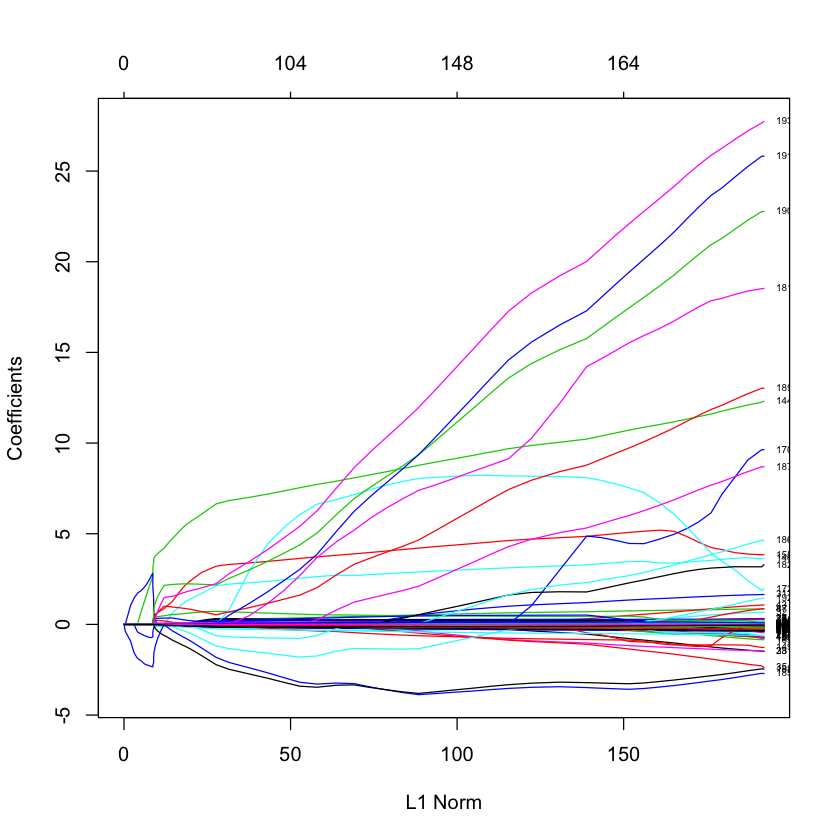

In [45]:
fit <- glmnet(x = ind, y = dep, alpha = 1, family = 'binomial')
plot(fit, label = T)

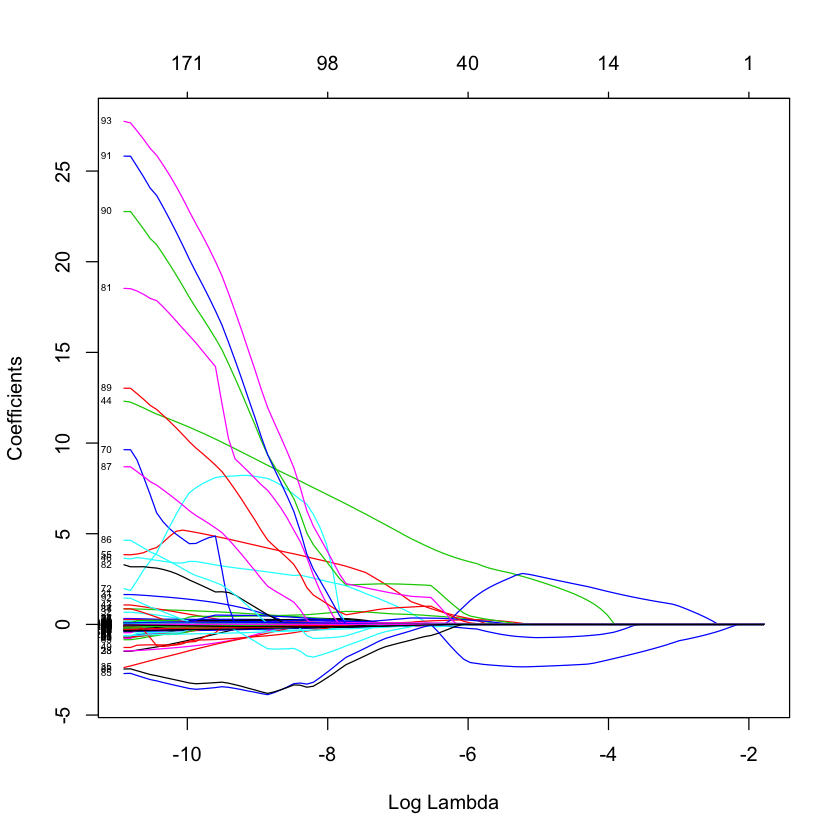

In [46]:
plot(fit, xvar='lambda',label = T)

In [47]:
# get %Dev on selected features
fit


Call:  glmnet(x = ind, y = dep, family = "binomial", alpha = 1) 

        Df      %Dev    Lambda
  [1,]   0 9.849e-13 1.678e-01
  [2,]   1 3.167e-02 1.529e-01
  [3,]   1 5.507e-02 1.393e-01
  [4,]   1 7.590e-02 1.270e-01
  [5,]   2 1.044e-01 1.157e-01
  [6,]   3 1.485e-01 1.054e-01
  [7,]   3 1.879e-01 9.604e-02
  [8,]   3 2.220e-01 8.751e-02
  [9,]   4 2.551e-01 7.973e-02
 [10,]   4 2.839e-01 7.265e-02
 [11,]   4 3.093e-01 6.620e-02
 [12,]   4 3.317e-01 6.032e-02
 [13,]   4 3.517e-01 5.496e-02
 [14,]   4 3.695e-01 5.007e-02
 [15,]   6 3.916e-01 4.563e-02
 [16,]   7 4.238e-01 4.157e-02
 [17,]   7 4.544e-01 3.788e-02
 [18,]   7 4.812e-01 3.451e-02
 [19,]   7 5.051e-01 3.145e-02
 [20,]   7 5.266e-01 2.865e-02
 [21,]  12 5.463e-01 2.611e-02
 [22,]  13 5.645e-01 2.379e-02
 [23,]  13 5.811e-01 2.168e-02
 [24,]  13 5.963e-01 1.975e-02
 [25,]  14 6.105e-01 1.800e-02
 [26,]  13 6.235e-01 1.640e-02
 [27,]  14 6.354e-01 1.494e-02
 [28,]  14 6.468e-01 1.361e-02
 [29,]  15 6.583e-01 1.240e-02
 [3

In [48]:
coef(fit, s = 1.842/exp(5)) # smallest value given from above

208 x 1 sparse Matrix of class "dgCMatrix"
                                                       1
(Intercept)                                 2.724611e-01
(Intercept)                                 .           
loan_amnt                                   .           
funded_amnt                                 .           
term 60 months                              .           
installment                                 4.876704e-03
emp_length1 year                            .           
emp_length10+ years                         .           
emp_length2 years                           .           
emp_length3 years                           .           
emp_length4 years                           .           
emp_length5 years                           .           
emp_length6 years                           .           
emp_length7 years                           .           
emp_length8 years                           .           
emp_length9 years                           .

### Cross Validation 

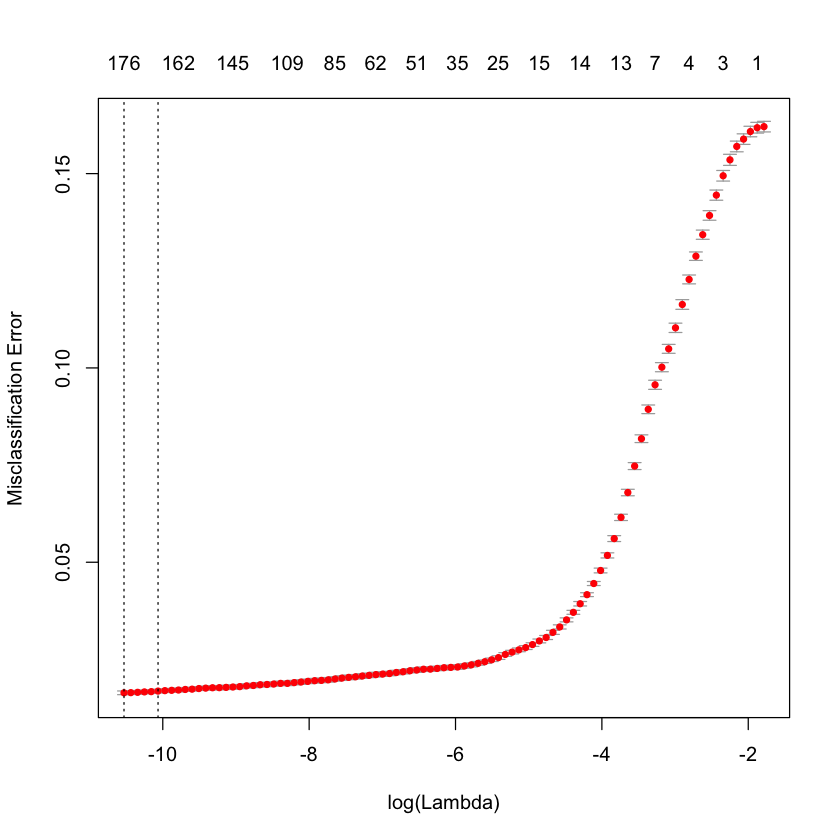

In [49]:
cv.fit <- cv.glmnet(x = ind, y = dep, family = 'binomial', type.measure = 'class')
plot(cv.fit)

In [50]:
coef(cv.fit, s = 'lambda.min')

208 x 1 sparse Matrix of class "dgCMatrix"
                                                       1
(Intercept)                                 1.060443e+03
(Intercept)                                 .           
loan_amnt                                   1.812044e-03
funded_amnt                                 7.667526e-05
term 60 months                              8.240755e-01
installment                                 7.904265e-02
emp_length1 year                           -9.996875e-03
emp_length10+ years                        -3.987341e-02
emp_length2 years                          -6.623341e-02
emp_length3 years                           7.693161e-03
emp_length4 years                           7.943448e-03
emp_length5 years                          -1.384236e-01
emp_length6 years                           1.319398e-04
emp_length7 years                           3.079627e-03
emp_length8 years                           4.220849e-02
emp_length9 years                          -3

In [51]:
train$loan_status_binary_num <- with(train, ifelse(loan_status_binary == 'paid', 1, 0))
test$loan_status_binary_num <- with(test, ifelse(loan_status_binary == 'paid', 1, 0))

In [52]:
# update dataset with selected features based on LASSO and Cross Validation
train.sub <- train[,c('loan_status_binary_num','term','installment','emp_length','delinq_2yrs','il_util',
                      'mths_since_recent_bc_dlq','home_ownership','mths_since_last_delinq','initial_list_status',
                      'mths_since_last_major_derog','mths_since_recent_inq','hardship_flag','hardship_loan_status',
                      'debt_settlement_flag','last_pymnt_from_issue_cat','settlement_since_issue','annual_inc_log')]
test.sub <- test[,c('loan_status_binary_num','term','installment','emp_length','delinq_2yrs','il_util',
                    'mths_since_recent_bc_dlq','home_ownership','mths_since_last_delinq','initial_list_status',
                    'mths_since_last_major_derog','mths_since_recent_inq','hardship_flag','hardship_loan_status',
                    'debt_settlement_flag','last_pymnt_from_issue_cat','settlement_since_issue','annual_inc_log')]

## Supervised Learning 

- Naive Bayes
- Logistic Regression
- Decision Tree

### Naive Bayes

In [54]:
library(e1071)
# fit Naive Bayes to the training set
cf_NB <- naiveBayes(as.factor(loan_status_binary_num) ~ ., data = train.sub)
# predict the test set
pred_NB <- predict(cf_NB, test.sub)
#accuracy
NB_accuracy <- mean(test.sub[,1] == pred_NB, na.rm = TRUE)
NB_accuracy

Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”Warning message in data.matrix(newdata):
“NAs introduced by coercion”

[1] 0.8318022

In [55]:
# confusion matrix
cm_NB <- table(test.sub[,1], pred_NB)
cm_NB

   pred_NB
        0     1
  0    45  6587
  1   169 33366

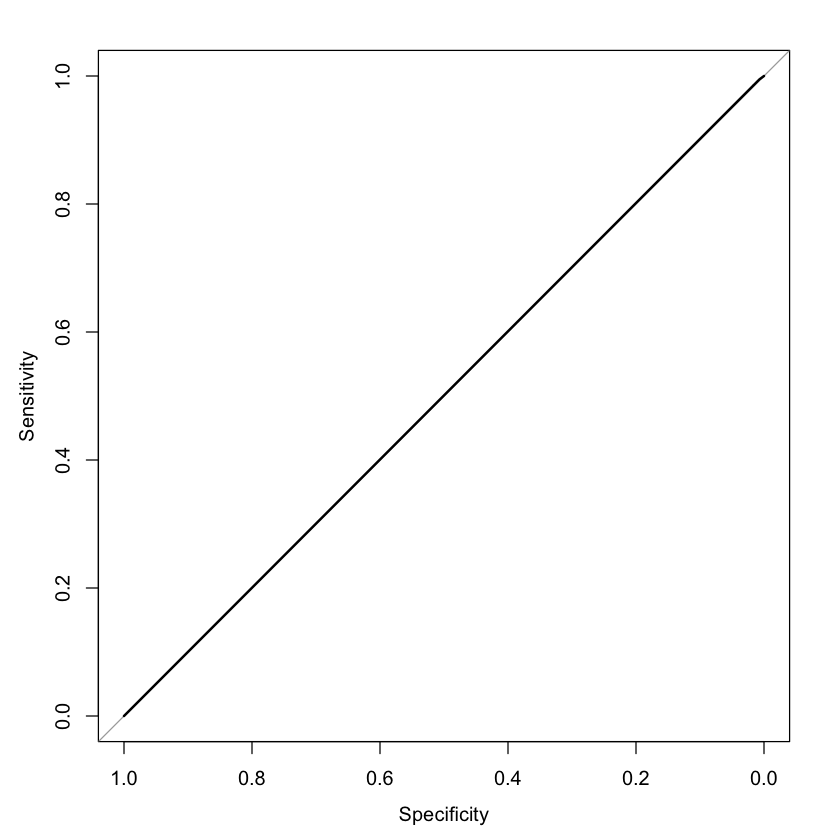

In [57]:
# ROC curve
library(pROC)
test.sub$loan_status_binary_num <- as.numeric(test.sub$loan_status_binary_num)
pred_NB <- as.numeric(pred_NB)
plot.roc(test.sub$loan_status_binary_num, pred_NB)

### Logistic Regression

In [58]:
# fit Logistic Regression to the training set
cf_LR <- glm(loan_status_binary_num ~ ., data = train.sub, family = 'binomial')
# predict the test set
pred_LR <- predict(cf_LR, type = 'response', newdata = test.sub[,-1])
pred_LR <- ifelse(pred_LR > 0.5, 1, 0)
#accuracy
LR_accuracy <- mean(test.sub[,1] == pred_LR, na.rm = TRUE)
LR_accuracy

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

[1] 0.8613538

In [59]:
# confusion matrix
cm_LR <- table(test.sub$loan_status_binary, pred_LR)
cm_LR

   pred_LR
        0     1
  0  1447  5185
  1   384 33151

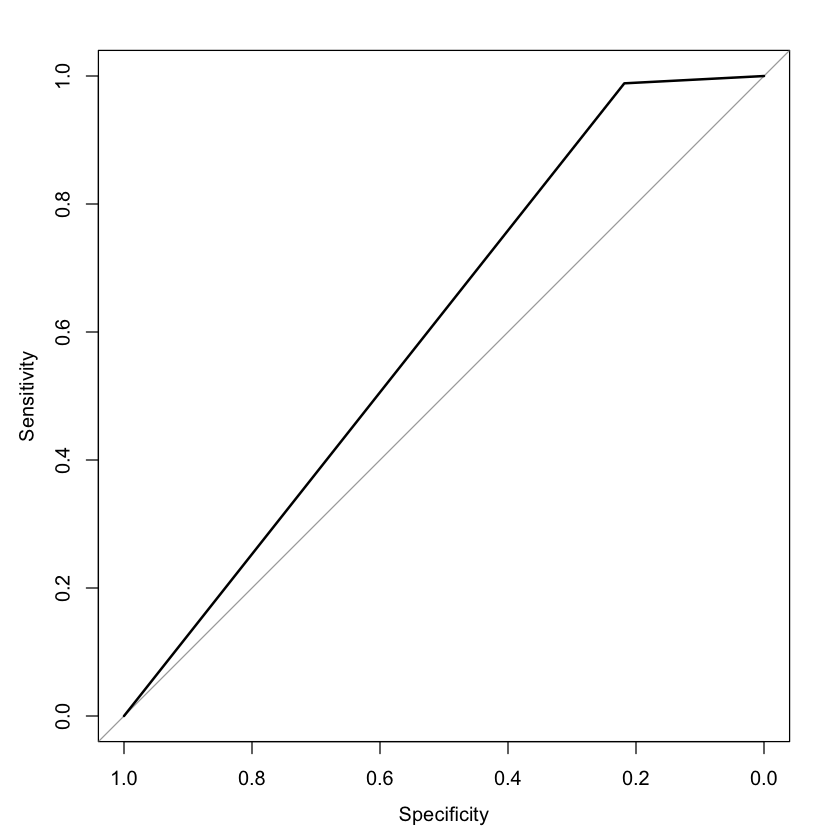

In [60]:
# ROC curve
plot.roc(test.sub$loan_status_binary, pred_LR)

### Decision Tree

In [61]:
library(rpart)
# fit Decision Tree to the training set
cf_DT <- rpart(loan_status_binary_num~., data = train.sub)
# predict the test set
pred_DT <- predict(cf_DT, newdata = test.sub[,-1])
pred_DT <- ifelse(pred_DT > 0.5, 1, 0)
#accuracy
DT_accuracy <- mean(test.sub[,1] == pred_DT, na.rm = TRUE)
DT_accuracy

[1] 0.853412

In [62]:
# confusion matrix
cm_DT <- table(test.sub$loan_status_binary_num, pred_DT)
cm_DT

   pred_DT
        0     1
  0   745  5887
  1     1 33534

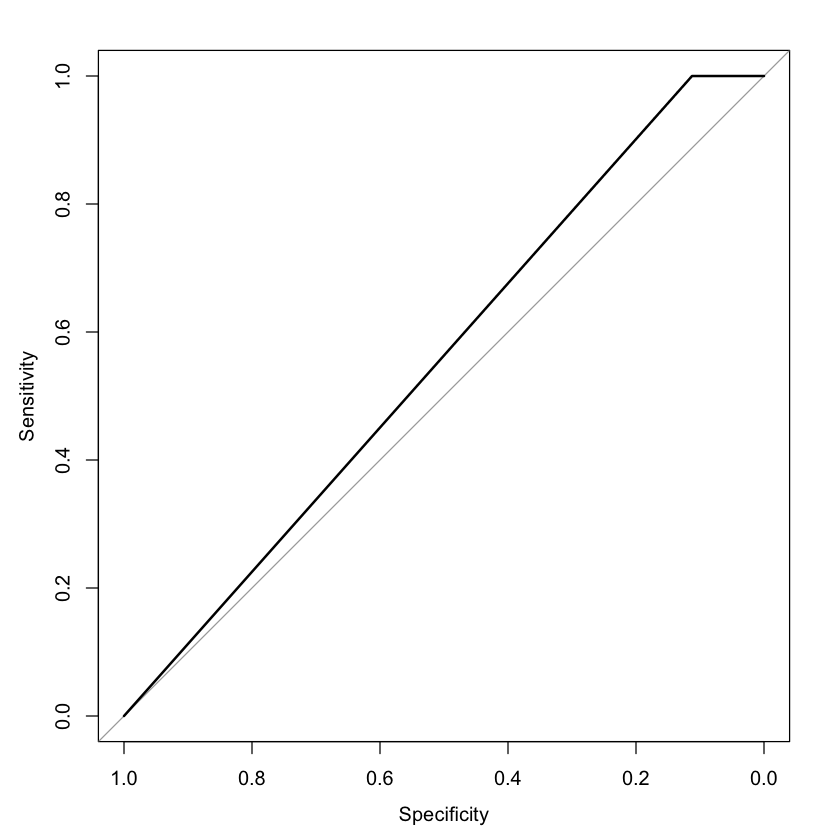

In [63]:
# ROC curve
plot.roc(test.sub$loan_status_binary_num, pred_DT)

### Relationship between loan status and selected features

In [64]:
summary(train.sub)

 loan_status_binary_num     term            installment       emp_length       
 Min.   :0.0000         Length:93720       Min.   :  30.12   Length:93720      
 1st Qu.:1.0000         Class :character   1st Qu.: 265.68   Class :character  
 Median :1.0000         Mode  :character   Median : 398.69   Mode  :character  
 Mean   :0.8379                            Mean   : 461.52                     
 3rd Qu.:1.0000                            3rd Qu.: 617.25                     
 Max.   :1.0000                            Max.   :1536.95                     
  delinq_2yrs        il_util          mths_since_recent_bc_dlq
 Min.   : 0.0000   Length:93720       Length:93720            
 1st Qu.: 0.0000   Class :character   Class :character        
 Median : 0.0000   Mode  :character   Mode  :character        
 Mean   : 0.3439                                              
 3rd Qu.: 0.0000                                              
 Max.   :22.0000                                              

          
            36 months  60 months
  paid          82165      29899
  past_due      13955       7868

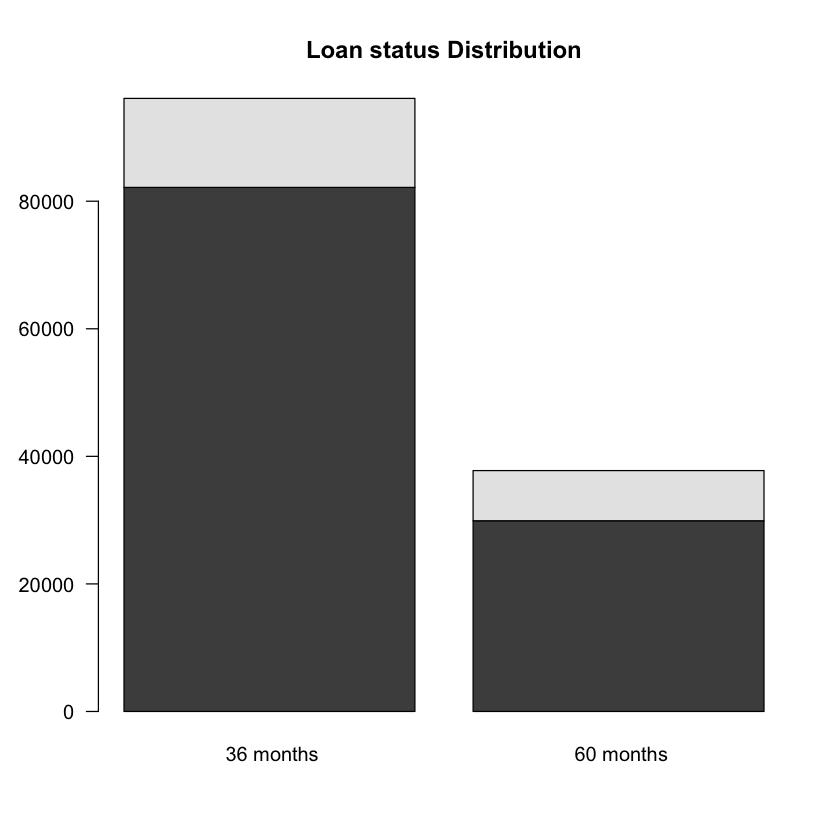

In [95]:
counts <- table(loan$loan_status_binary, loan$term)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           < 1 year 1 year 10+ years 2 years 3 years 4 years 5 years 6 years
  paid         8390   7235     39455    9848    8901    6524    6747    4502
  past_due     1692   1468      6892    2001    1834    1265    1315     877
          
           7 years 8 years 9 years   n/a
  paid        3721    5278    4385  7078
  past_due     744    1052     817  1866

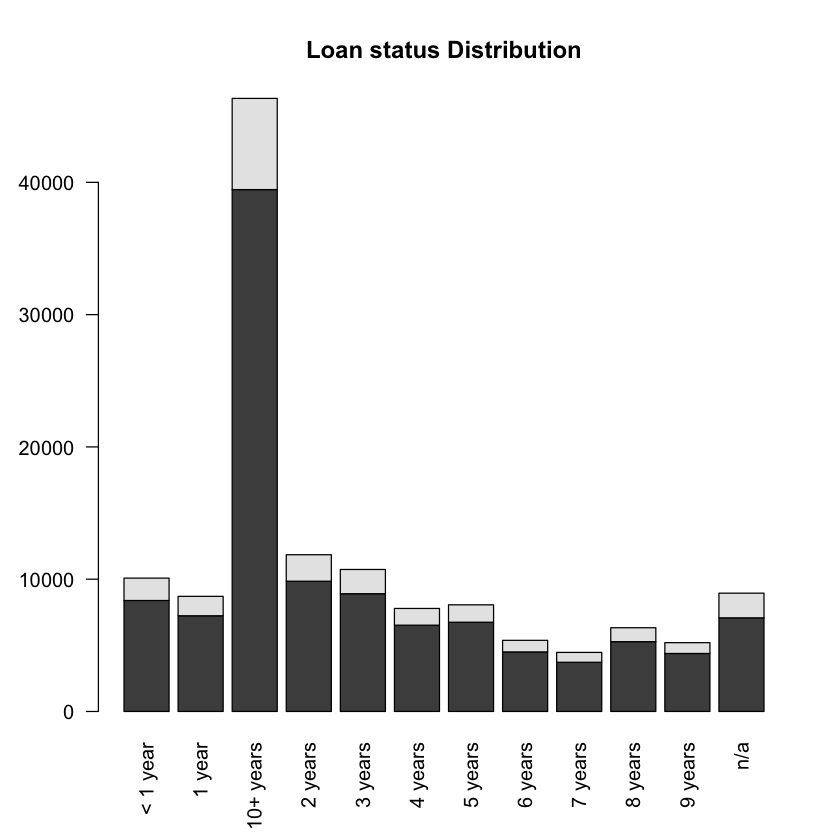

In [97]:
counts <- table(loan$loan_status_binary, loan$emp_length)
counts
barplot(counts, main = 'Loan status Distribution',las = 2)

          
           (-0.01,32] (32,96] (96,558] no_il
  paid          10825   80883     8542 11814
  past_due       1493   16402     2094  1834

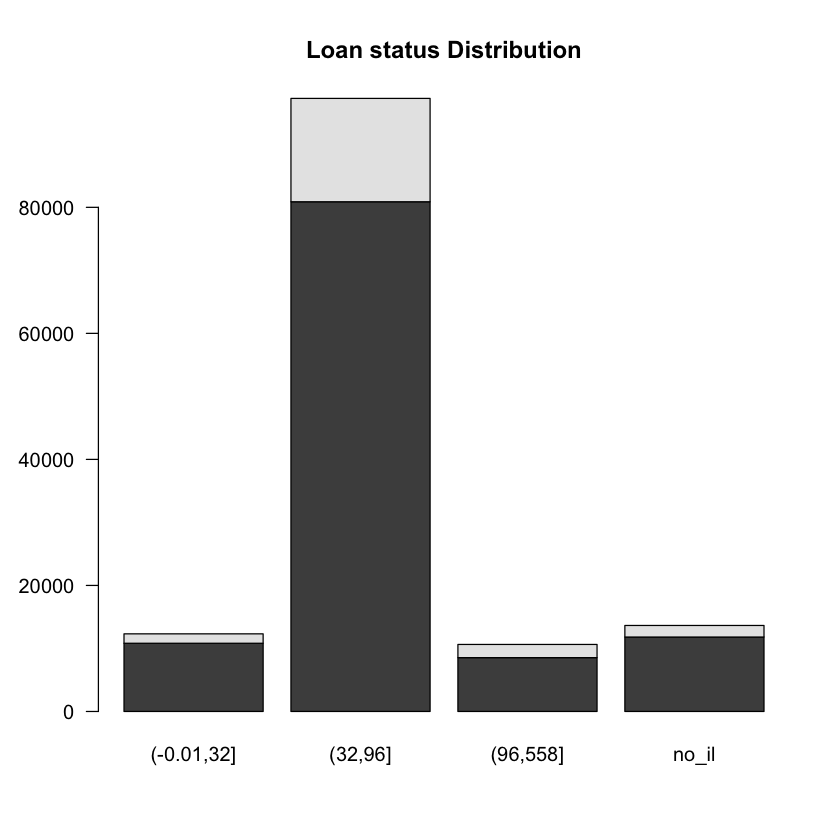

In [65]:
counts <- table(loan$loan_status_binary, loan$il_util)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           (-1,10] (10,36] (36,73] (73,188] not_avail
  paid        3089   10859   11395     2584     84137
  past_due     638    2379    2292      520     15994

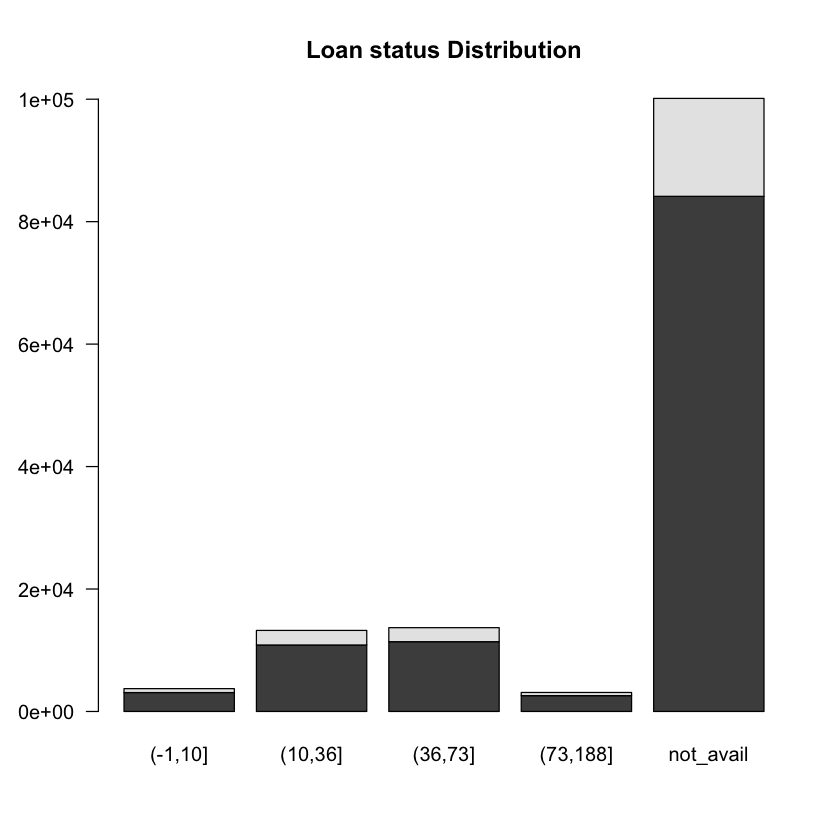

In [66]:
counts <- table(loan$loan_status_binary, loan$mths_since_recent_bc_dlq)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           MORTGAGE   OWN  RENT
  paid        57547 13562 40955
  past_due     9282  2632  9909

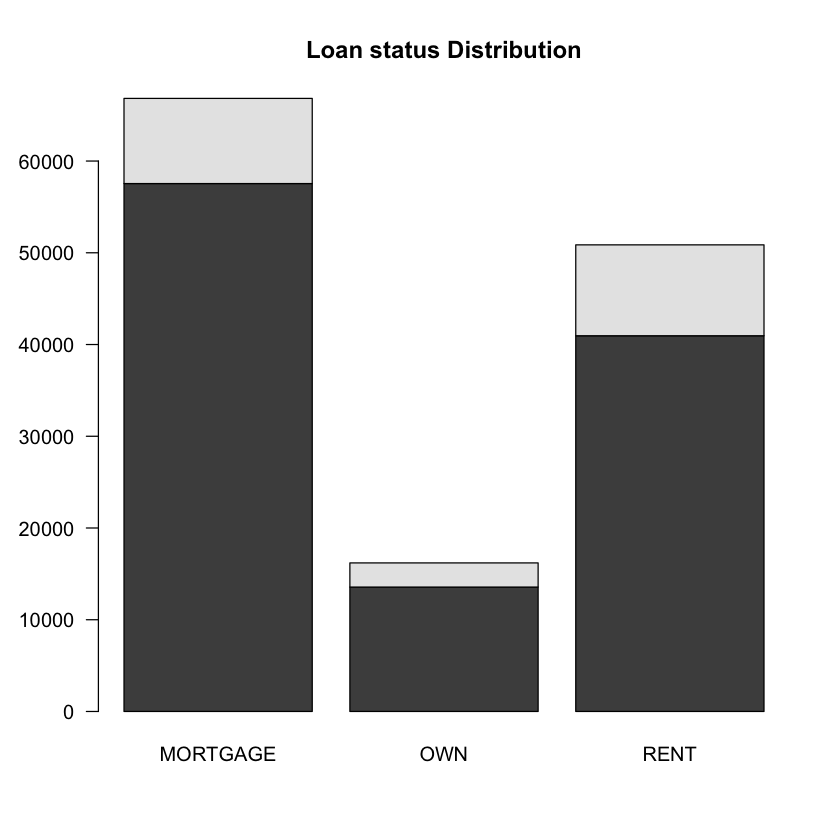

In [98]:
counts <- table(loan$loan_status_binary, loan$home_ownership)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           (-1,7] (30,68] (68,192] (7,30] not_avail
  paid       6101   23152     5519  22695     54597
  past_due   1301    4642     1104   4808      9968

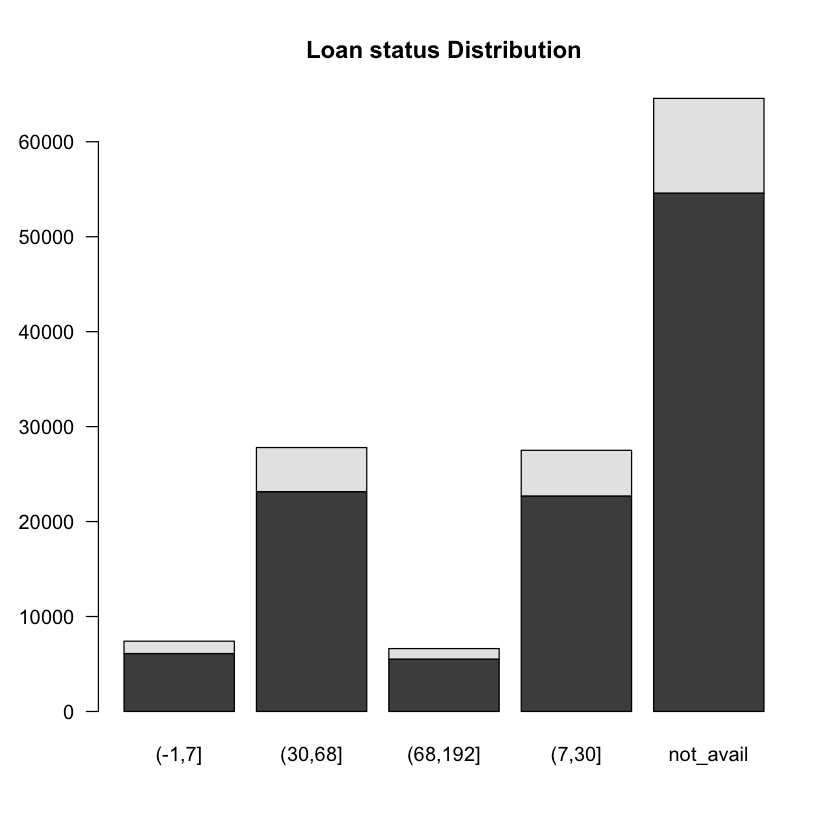

In [99]:
counts <- table(loan$loan_status_binary, loan$mths_since_last_delinq)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
               f     w
  paid     16438 95626
  past_due  4518 17305

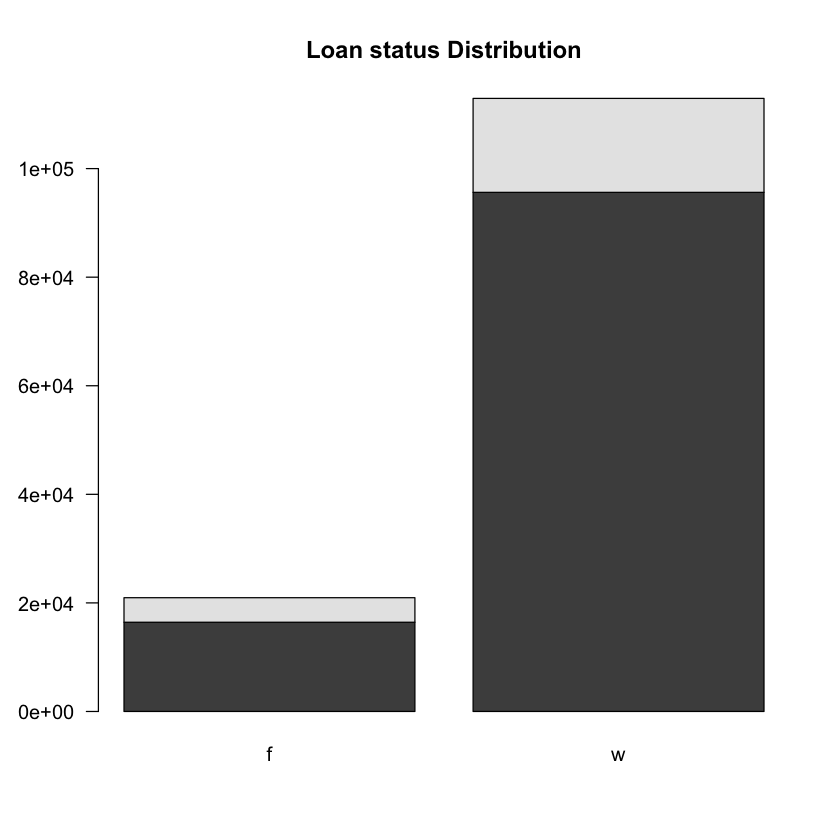

In [100]:
counts <- table(loan$loan_status_binary, loan$initial_list_status)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           (-1,14] (14,44] (44,73] (73,197] not_avail
  paid        3340   12362   12511     2890     80961
  past_due     761    2843    2673      694     14852

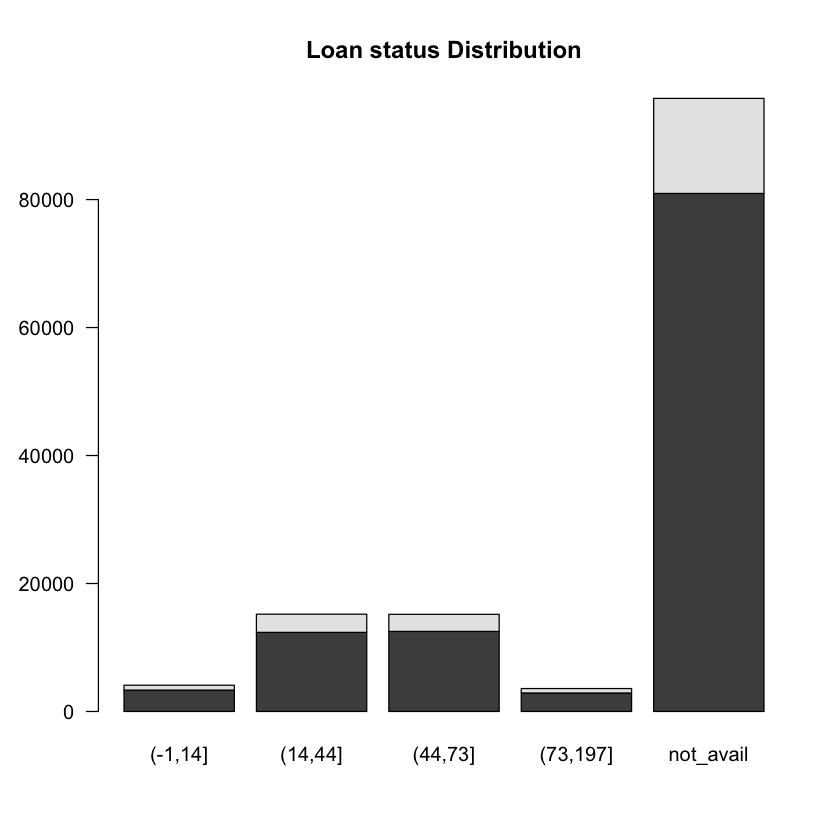

In [101]:
counts <- table(loan$loan_status_binary, loan$mths_since_last_major_derog)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           (-1,1] (1,5] (16,25] (5,16] not_avail
  paid      18944 31168    9577  40026     12349
  past_due   4845  7039    1367   7123      1449

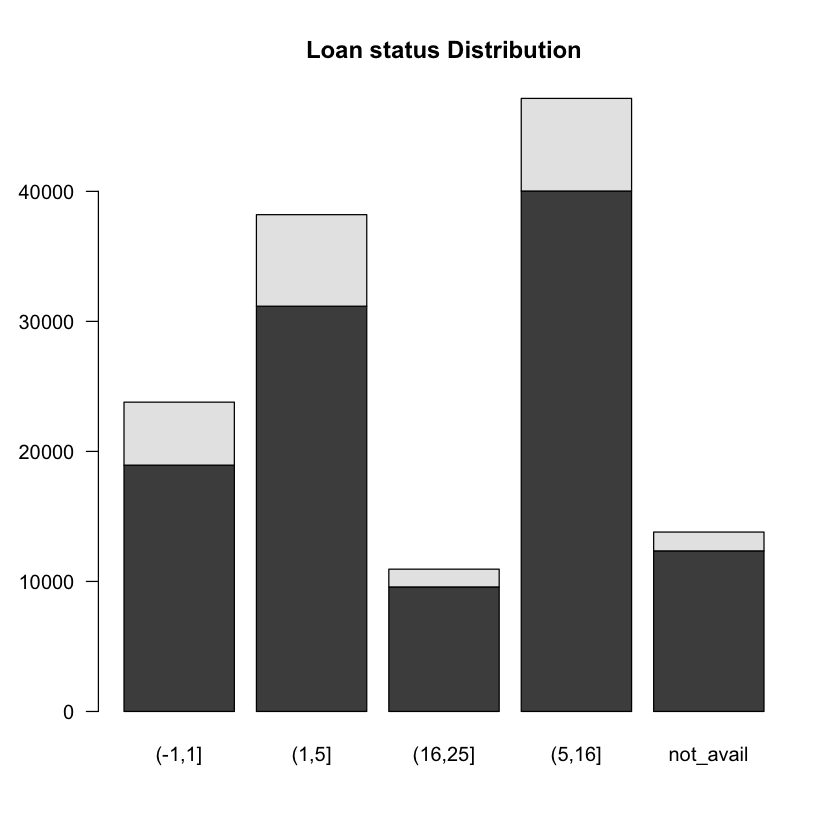

In [102]:
counts <- table(loan$loan_status_binary, loan$mths_since_recent_inq)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
                N      Y
  paid     112064      0
  past_due  21748     75

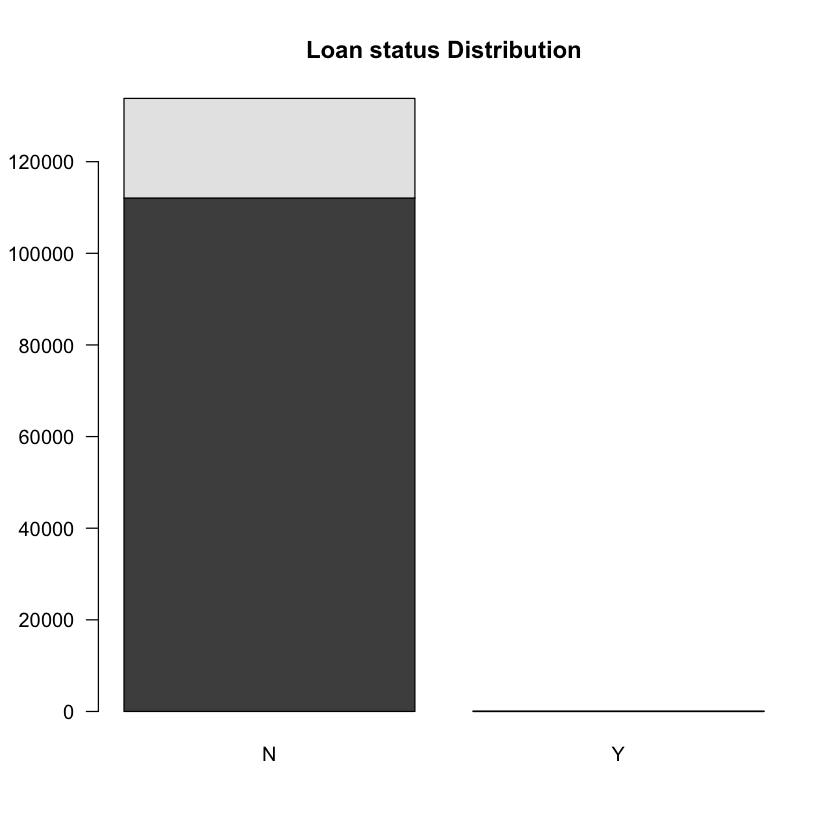

In [103]:
counts <- table(loan$loan_status_binary, loan$hardship_flag)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           Current In Grace Period Late (16-30 days) Late (31-120 days)
  paid         203              97               144                 12
  past_due      69             186               312                 21
          
           no_hardship
  paid          111608
  past_due       21235

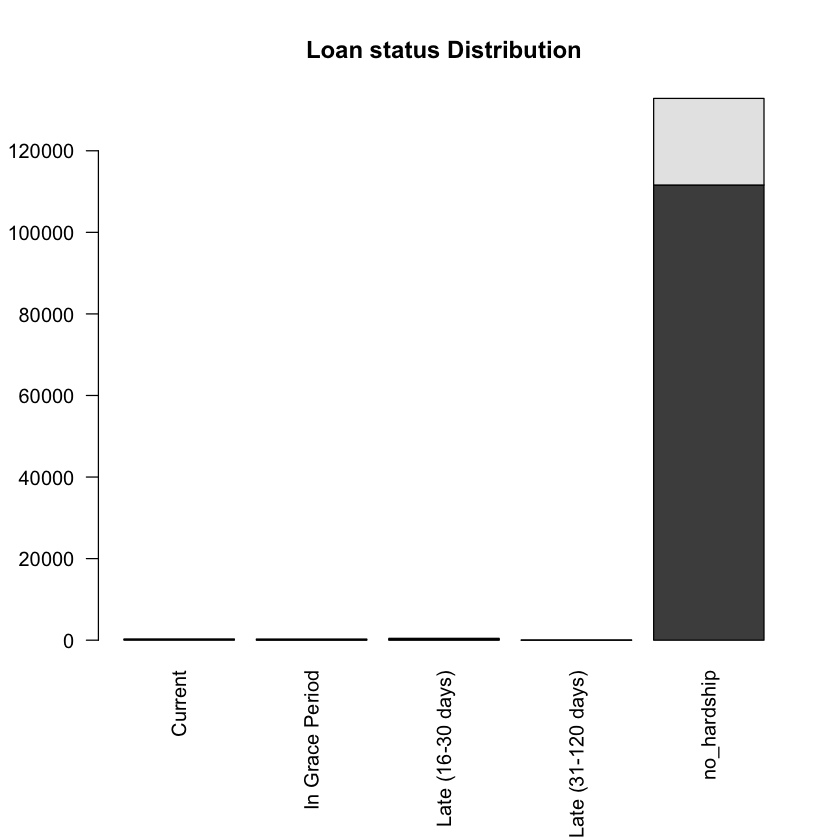

In [106]:
counts <- table(loan$loan_status_binary, loan$hardship_loan_status)
counts
par(mar = c(8.1,4.1,4.1,2.1))
barplot(counts, main = 'Loan status Distribution',las = 2)

          
                N      Y
  paid     112061      3
  past_due  19330   2493

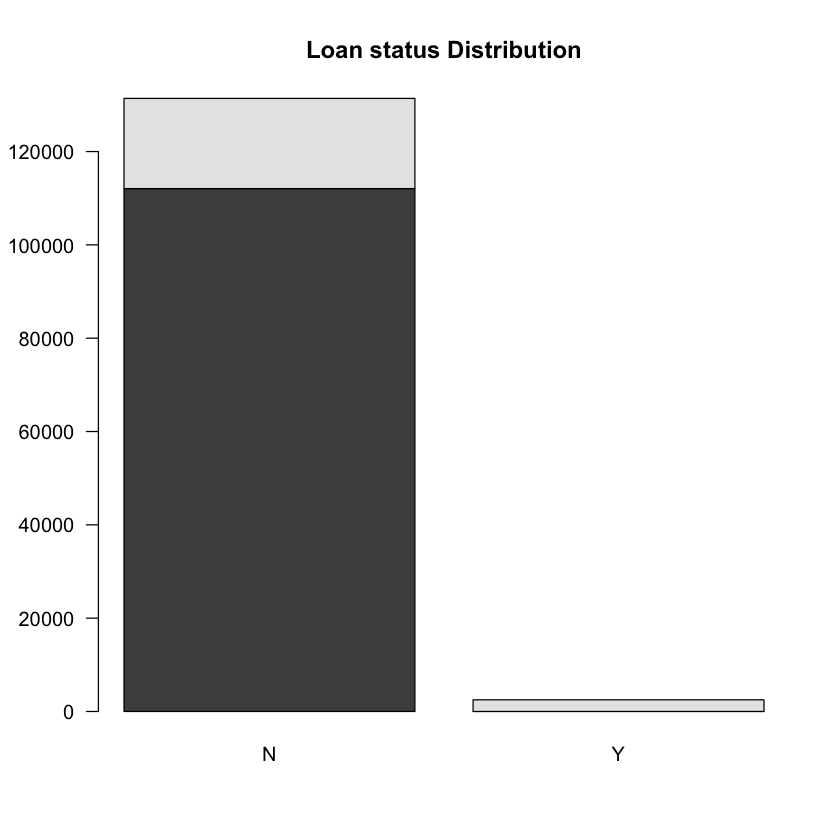

In [107]:
counts <- table(loan$loan_status_binary, loan$debt_settlement_flag)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

          
           (-1,0] (0,30] (184,275] (275,366] (30,92] (366,549] (549,732]
  paid        492    401      4698      5599    3075     12307     12878
  past_due      0     54      2744      2789     885      5485      3990
          
           (732,915] (92,184] no pymnt
  paid         68558     4056        0
  past_due      3396     2332      148

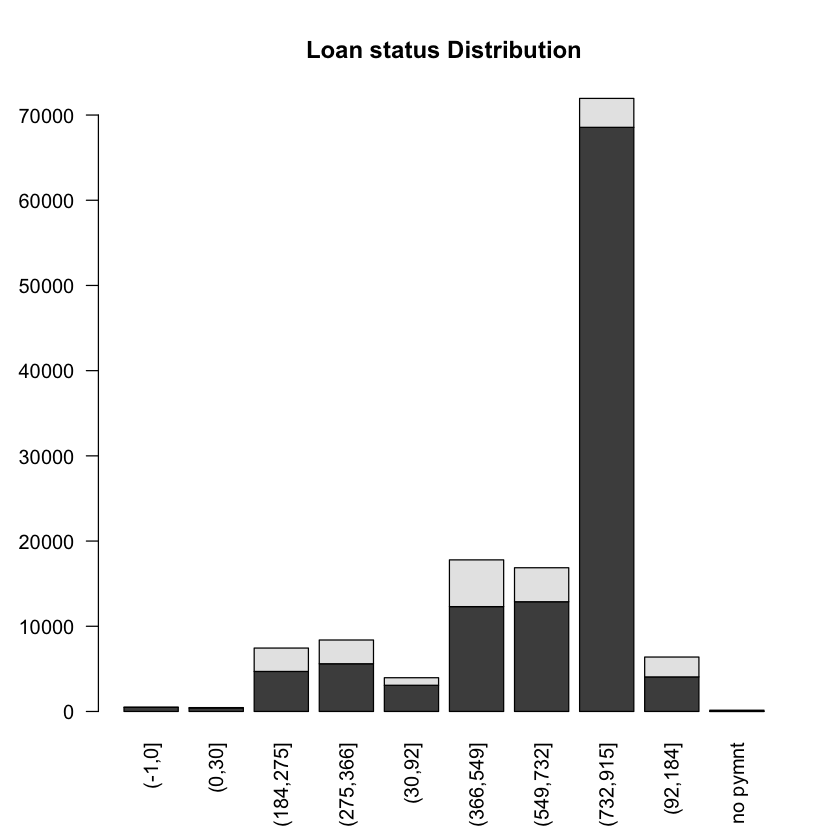

In [109]:
counts <- table(loan$loan_status_binary, loan$last_pymnt_from_issue_cat)
counts
barplot(counts, main = 'Loan status Distribution',las = 2)

          
           (14,27] (2,14] (27,29] no_settlement
  paid           2      1       0        112061
  past_due    2134    251     108         19330

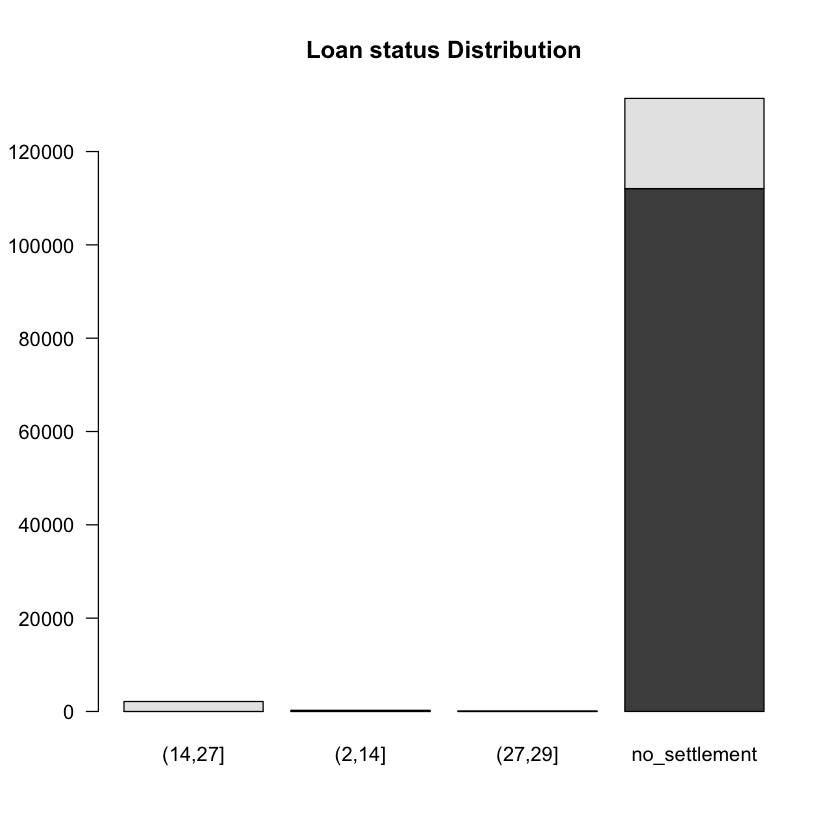

In [110]:
counts <- table(loan$loan_status_binary, loan$settlement_since_issue)
counts
barplot(counts, main = 'Loan status Distribution',las = 1)

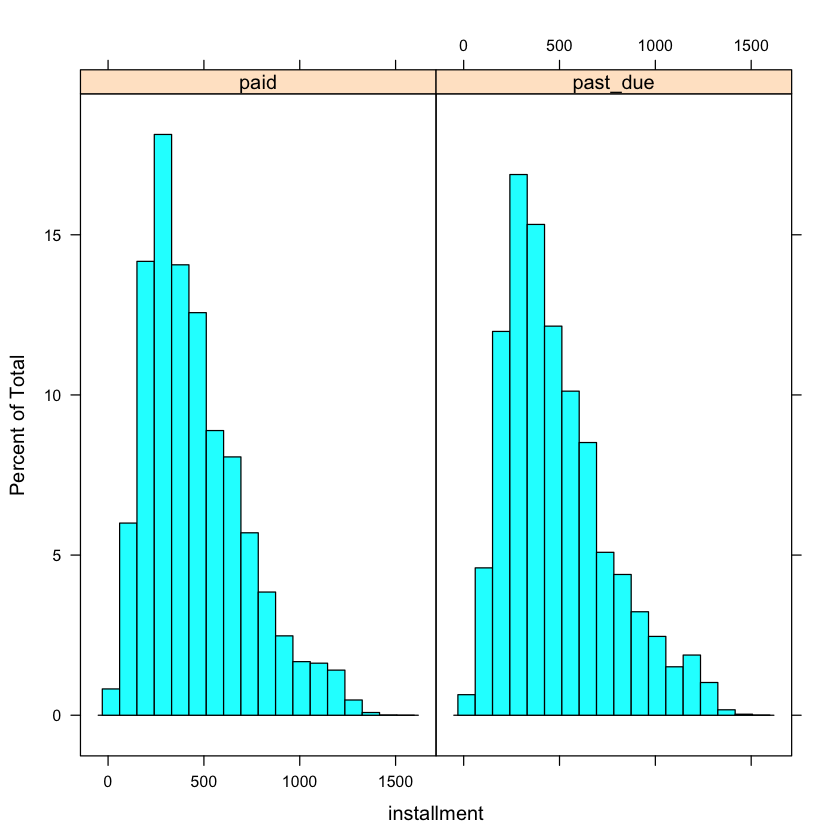

In [112]:
histogram(~installment | loan_status_binary, data = loan)

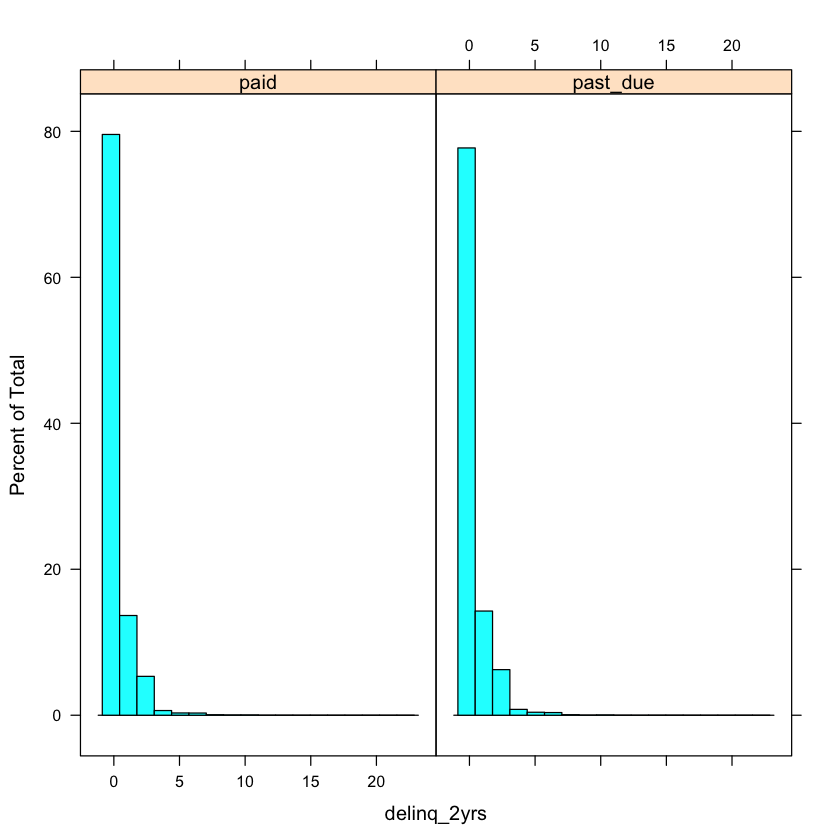

In [67]:
library(lattice)
histogram(~delinq_2yrs | loan_status_binary, data = loan)

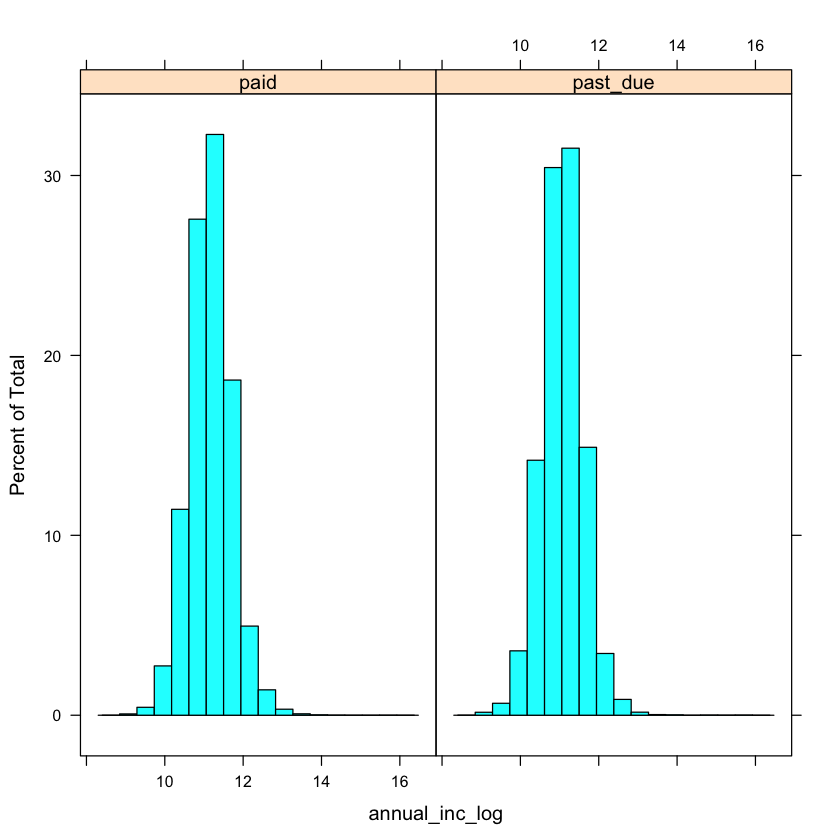

In [113]:
histogram(~annual_inc_log | loan_status_binary, data = loan)